Cargando datos y realizando split basado en fecha...
Datos cargados exitosamente.
Train original shape: (54860, 24)
Test original shape: (13249, 24)
Dimensiones de los conjuntos después del split por fecha:
  Train: X=(54860, 23), y=(54860,)
  Test Final: X=(13249, 23), y=(13249,)

Aplicando transformación logarítmica al target (y)...
Realizando selección de características con Mutual Information...
Características seleccionadas (17): ['num_yendo_a_pista_aircrafts', 'en_camino_antes', 'holding_point_id', 'wind_dir', 'runway', 'holding_ocupado', 'num_holding_aircrafts', 'tiempo_desde_ultimo_despegue', 'hour_sin', 'pista_ocupada']...
Dimensiones después de la selección de características:
  Train: (54860, 17)
  Test Final: (13249, 17)

Iniciando entrenamiento y optimización de modelos...

--- 2. Optimizando Random Forest ---
Iniciando GridSearchCV para Random Forest con 36 combinaciones y cv=3 (108 fits)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
GridSearchCV Random

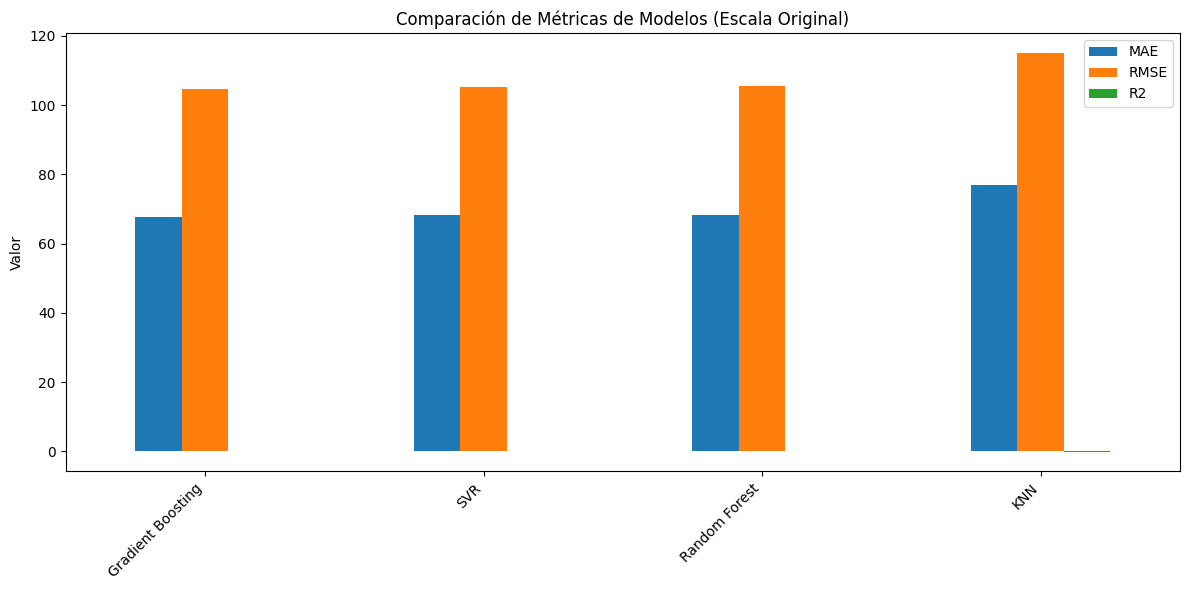

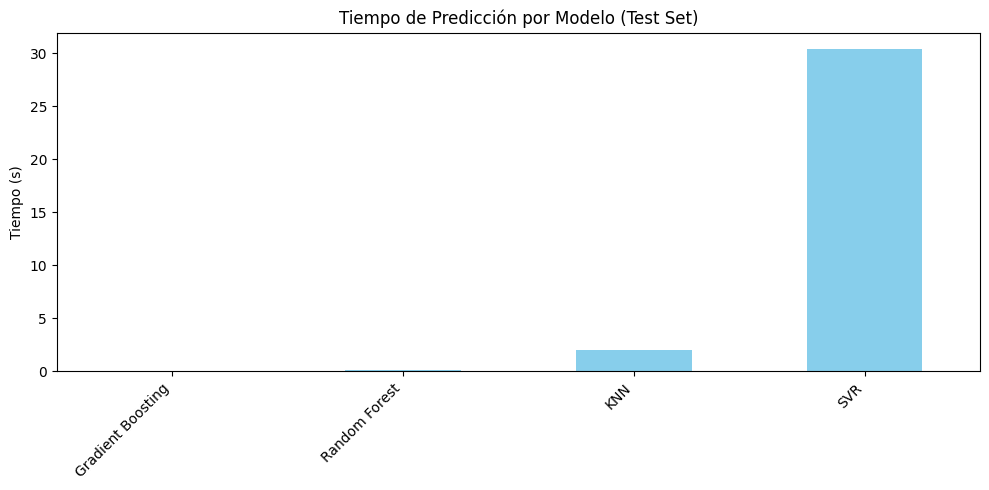


--- Análisis Detallado del Mejor Modelo: Gradient Boosting ---
Mejores Parámetros encontrados:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.9, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

Métricas de Evaluación Final (Gradient Boosting):
MAE                       67.627449
RMSE                     104.778787
R2                         0.154621
Tiempo Predicción (s)      0.063238
Name: Gradient Boosting, dtype: float64


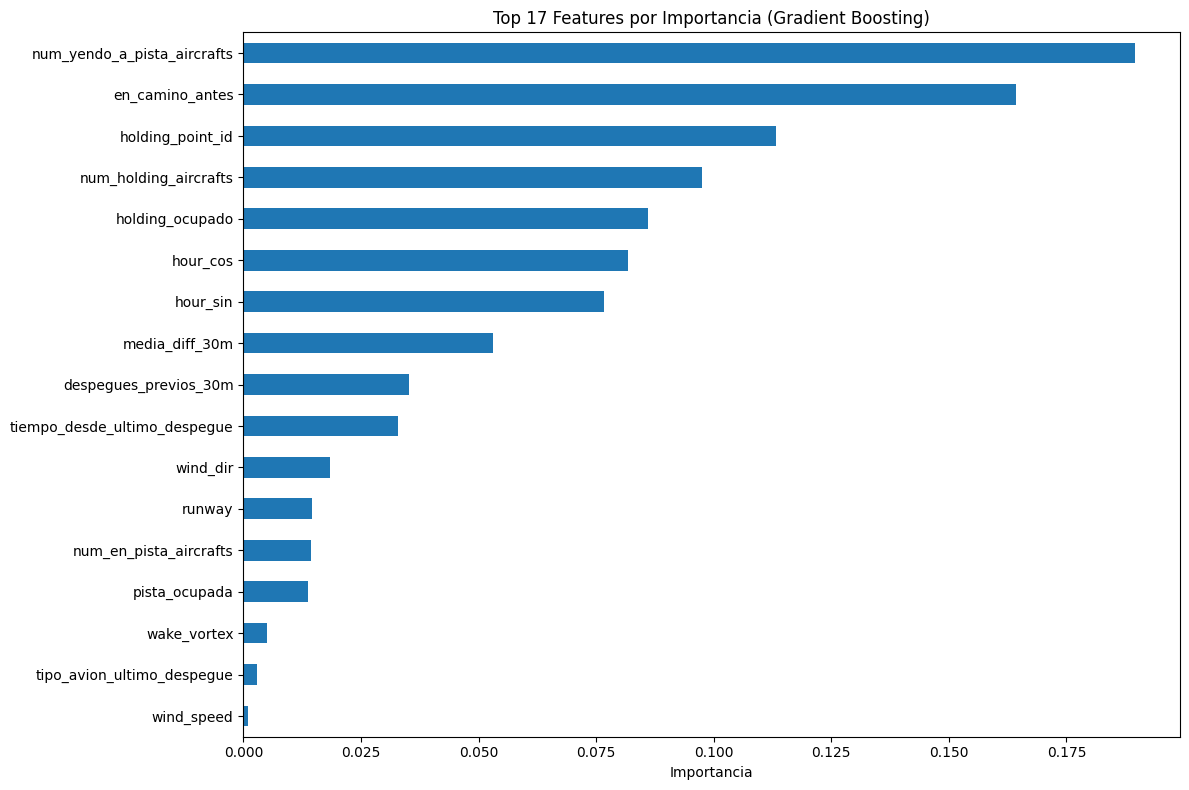

In [5]:
# CODE:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for better plots
from xgboost import XGBRegressor
# Removed incorrect EarlyStopping import, will use fit parameter
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
# StandardScaler removed as data is pre-scaled
# Pipeline removed as scaler is not needed here for SVR/KNN anymore
import time
import warnings

# Ignorar advertencias
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# --- DATA LOADING AND DATE-BASED SPLIT ---
print("Cargando datos y realizando split basado en fecha...")
try:
    # Ensure file paths are correct - Assuming they are relative to the script location
    # Or adjust paths as needed
    train_path = "../../data/train/train_con_outliers.parquet"
    test_path = "../../data/test/test_con_outliers.parquet"
    columns_to_drop = [
    "media_diff_1h", "media_diff_45m", "media_diff_20m", "media_diff_10m", "media_diff_5m",
    "despegues_previos_1h", "despegues_previos_45m", "despegues_previos_20m", "despegues_previos_10m", "despegues_previos_5m",
    'distancias_holdings_0', 'distancias_holdings_1', 'distancias_holdings_2', 'distancia_en_pista_0', 'distancia_en_pista_1',
    'distancia_yendo_a_pista_0', 'distancia_yendo_a_pista_1', 'distancia_yendo_a_pista_2',
    'tiempo_holding_0', 'tiempo_holding_1', 'tiempo_holding_2',
    "temp", "wind_shear"
    ]
    train = pd.read_parquet(train_path).dropna().drop(columns=columns_to_drop).drop("ts", axis=1)
    test = pd.read_parquet(test_path).dropna().drop(columns=columns_to_drop).drop("ts", axis=1)
    print("Datos cargados exitosamente.")
    print(f"Train original shape: {train.shape}")
    print(f"Test original shape: {test.shape}")
except FileNotFoundError:
    print(f"Error: Ensure '{train_path}' and '{test_path}' exist.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Separate features (X) and target (y)
X_train = train.drop("tiempo_hasta_despegue", axis=1)
y_train = train['tiempo_hasta_despegue']

X_test_final = test.drop(columns=['tiempo_hasta_despegue'])
y_test_final = test['tiempo_hasta_despegue']

# Store original 'ts' and other potential segmentation columns from test set
X_test_final_original_features = X_test_final[['runway', 'holding_point_id']].copy()

# Drop 'ts' from the final test feature set
X_test_final = X_test_final

print(f"Dimensiones de los conjuntos después del split por fecha:")
print(f"  Train: X={X_train.shape}, y={y_train.shape}")
print(f"  Test Final: X={X_test_final.shape}, y={y_test_final.shape}")

# --- LOGARITHMIC TRANSFORMATION OF TARGET ---
print("\nAplicando transformación logarítmica al target (y)...")
y_train_log =   np.log1p(y_train)
# Note: y_test_final remains in original scale for final evaluation

# --- FEATURE SELECTION USING MUTUAL INFORMATION ---
print("Realizando selección de características con Mutual Information...")
# Use the training data AFTER the split
mi_scores = mutual_info_regression(X_train, y_train_log) # Use log-transformed target for MI
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Select features based on a threshold (adjust if needed)
# Keeping a few more features than potentially optimal for diverse models
threshold = 0.005
selected_features = mi_scores[mi_scores > threshold].index.tolist()
if len(selected_features) == 0: # Fallback in case no feature has MI > threshold
    print(f"Advertencia: Ninguna característica con MI > {threshold}. Usando todas las características.")
    selected_features = X_train.columns.tolist()
elif len(selected_features) < 5: # Ensure a minimum number of features
     print(f"Advertencia: Solo {len(selected_features)} características superan el umbral. Seleccionando las top 10.")
     selected_features = mi_scores.nlargest(10).index.tolist()


print(f"Características seleccionadas ({len(selected_features)}): {selected_features[:10]}...") # Print first 10

# Apply feature selection to all sets
X_train_selected = X_train[selected_features].copy()
# Make sure to select same features from the final test set
X_test_selected = X_test_final[selected_features].copy()

print(f"Dimensiones después de la selección de características:")
print(f"  Train: {X_train_selected.shape}")
print(f"  Test Final: {X_test_selected.shape}")

## --- FUNCTION TO EVALUATE MODELS ---
def evaluate_model(model, X_test_data, y_test_original):
    start_time = time.time()
    # Ensure X_test_data has features in the same order as training
    X_test_data = X_test_data[model.feature_names_in_] if hasattr(model, 'feature_names_in_') else X_test_data # XGBoost/RF/GB have this
    y_pred_log = model.predict(X_test_data)
    elapsed_time = time.time() - start_time

    # --- INVERT THE LOG TRANSFORMATION ---
    y_pred_original = np.expm1(y_pred_log) # exp(x) - 1

    # Ensure predictions are non-negative (time cannot be negative)
    # y_pred_original[y_pred_original < 0] = 0

    # Calculate metrics using original scale values
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)

    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Tiempo Predicción (s)': elapsed_time,
        'predictions': y_pred_original 
    }

## --- MODEL TRAINING AND HYPERPARAMETER TUNING ---
print("\nIniciando entrenamiento y optimización de modelos...")
results = {}
models = {} # Store trained models

CV_FOLDS = 3 
SCORING_METRIC = 'neg_mean_absolute_error'

## 2. Random Forest with optimization
print("\n--- 2. Optimizando Random Forest ---")
rf_params = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [10, 15, None], 
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3] 
}
# Combinations: 3 * 3 * 2 * 2 = 36. Fits = 36 * 3 = 108

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=CV_FOLDS, scoring=SCORING_METRIC, n_jobs=-1, verbose=1)

n_combinations_rf = np.prod([len(v) for v in rf_params.values()])
print(f"Iniciando GridSearchCV para Random Forest con {n_combinations_rf} combinaciones y cv={CV_FOLDS} ({n_combinations_rf * CV_FOLDS} fits)...")
start_time_rf_tune = time.time()
rf_grid.fit(X_train_selected, y_train_log) # Use selected (unscaled) features
elapsed_time_rf_tune = time.time() - start_time_rf_tune

print(f"GridSearchCV Random Forest terminado en {elapsed_time_rf_tune:.2f}s")
print(f"Mejores parámetros Random Forest (GridSearchCV): {rf_grid.best_params_}")

best_rf = rf_grid.best_estimator_
print("Evaluando mejor Random Forest en conjunto de test final...")
rf_eval_results = evaluate_model(best_rf, X_test_selected, y_test_final)
print(f"Resultados Random Forest: { {k: v for k, v in rf_eval_results.items() if k != 'predictions'} }")
results['Random Forest'] = {k: v for k, v in rf_eval_results.items() if k != 'predictions'}
models['Random Forest'] = best_rf


## 3. Gradient Boosting with optimization
print("\n--- 3. Optimizando Gradient Boosting ---")
gb_params = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [3, 4, 5],        
    'learning_rate': [0.05, 0.1],   
    'subsample': [0.9, 1.0]         
}
# Combinations: 3 * 3 * 2 * 2 = 36. Fits = 36 * 3 = 108

gb = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, cv=CV_FOLDS, scoring=SCORING_METRIC, n_jobs=-1, verbose=1)

n_combinations_gb = np.prod([len(v) for v in gb_params.values()])
print(f"Iniciando GridSearchCV para Gradient Boosting con {n_combinations_gb} combinaciones y cv={CV_FOLDS} ({n_combinations_gb * CV_FOLDS} fits)...")
start_time_gb_tune = time.time()
gb_grid.fit(X_train_selected, y_train_log) # Use selected (unscaled) features
elapsed_time_gb_tune = time.time() - start_time_gb_tune

print(f"GridSearchCV Gradient Boosting terminado en {elapsed_time_gb_tune:.2f}s")
print(f"Mejores parámetros Gradient Boosting (GridSearchCV): {gb_grid.best_params_}")

best_gb = gb_grid.best_estimator_
print("Evaluando mejor Gradient Boosting en conjunto de test final...")
gb_eval_results = evaluate_model(best_gb, X_test_selected, y_test_final)
print(f"Resultados Gradient Boosting: { {k: v for k, v in gb_eval_results.items() if k != 'predictions'} }")
results['Gradient Boosting'] = {k: v for k, v in gb_eval_results.items() if k != 'predictions'}
models['Gradient Boosting'] = best_gb


## 4. SVR with optimization (No Pipeline needed as no scaling step)
print("\n--- 4. Optimizando SVR ---")
svr_params = {
    'kernel': ['rbf'], # Linear often too simple, poly too slow
    'C': [1, 10, 50], # Added 50
    'epsilon': [0.1, 0.2] # Added 0.2
}
# Combinations: 1 * 3 * 2 = 6. Fits = 6 * 3 = 18

# Train SVR directly on selected (unscaled) features
svr = SVR()
svr_grid = GridSearchCV(svr, svr_params, cv=CV_FOLDS, scoring=SCORING_METRIC, n_jobs=-1, verbose=1)

n_combinations_svr = np.prod([len(v) for v in svr_params.values()])
print(f"Iniciando GridSearchCV para SVR con {n_combinations_svr} combinaciones y cv={CV_FOLDS} ({n_combinations_svr * CV_FOLDS} fits)...")
start_time_svr_tune = time.time()
svr_grid.fit(X_train_selected, y_train_log) # Use selected (unscaled) features
elapsed_time_svr_tune = time.time() - start_time_svr_tune

print(f"GridSearchCV SVR terminado en {elapsed_time_svr_tune:.2f}s")
print(f"Mejores parámetros SVR (GridSearchCV): {svr_grid.best_params_}")

best_svr = svr_grid.best_estimator_
print("Evaluando mejor SVR en conjunto de test final...")
svr_eval_results = evaluate_model(best_svr, X_test_selected, y_test_final)
print(f"Resultados SVR: { {k: v for k, v in svr_eval_results.items() if k != 'predictions'} }")
results['SVR'] = {k: v for k, v in svr_eval_results.items() if k != 'predictions'}
models['SVR'] = best_svr


## 5. KNN with optimization (No Pipeline needed as no scaling step)
print("\n--- 5. Optimizando KNN ---")
knn_params = {
    'n_neighbors': [5, 10, 15], # Added 15
    'weights': ['uniform', 'distance'], # Added uniform
    'p': [1, 2] # Manhattan and Euclidean distance
}
# Combinations: 3 * 2 * 2 = 12. Fits = 12 * 3 = 36

# Train KNN directly on selected (unscaled) features
knn = KNeighborsRegressor(n_jobs=-1)
knn_grid = GridSearchCV(knn, knn_params, cv=CV_FOLDS, scoring=SCORING_METRIC, n_jobs=-1, verbose=1)

n_combinations_knn = np.prod([len(v) for v in knn_params.values()])
print(f"Iniciando GridSearchCV para KNN con {n_combinations_knn} combinaciones y cv={CV_FOLDS} ({n_combinations_knn * CV_FOLDS} fits)...")
start_time_knn_tune = time.time()
knn_grid.fit(X_train_selected, y_train_log) # Use selected (unscaled) features
elapsed_time_knn_tune = time.time() - start_time_knn_tune

print(f"GridSearchCV KNN terminado en {elapsed_time_knn_tune:.2f}s")
print(f"Mejores parámetros KNN (GridSearchCV): {knn_grid.best_params_}")

best_knn = knn_grid.best_estimator_
print("Evaluando mejor KNN en conjunto de test final...")
knn_eval_results = evaluate_model(best_knn, X_test_selected, y_test_final)
print(f"Resultados KNN: { {k: v for k, v in knn_eval_results.items() if k != 'predictions'} }")
results['KNN'] = {k: v for k, v in knn_eval_results.items() if k != 'predictions'}
models['KNN'] = best_knn


## --- COMPARISON OF MODELS ---
print("\n--- Comparación Final de Modelos ---")
if not results:
    print("No se pudo entrenar ningún modelo exitosamente.")
else:
    results_df = pd.DataFrame(results).T.sort_values(by='MAE') # Sort by MAE ascending
    print(results_df)

    # --- Basic Metrics Comparison Plot ---
    try:
        plt.figure(figsize=(12, 6))
        metrics_to_plot = ['MAE', 'RMSE', 'R2']
        available_metrics = [m for m in metrics_to_plot if m in results_df.columns]
        if available_metrics:
            results_df[available_metrics].plot(kind='bar', ax=plt.gca()) # Use ax=plt.gca()
            plt.title('Comparación de Métricas de Modelos (Escala Original)')
            plt.ylabel('Valor')
            plt.xticks(rotation=45, ha='right')
            plt.legend(loc='best')
            plt.tight_layout()
            plt.show()
        else:
            print("No hay métricas MAE, RMSE o R2 disponibles para plotear.")
    except Exception as e:
        print(f"Error al generar plot de comparación de métricas: {e}")

    # --- Prediction Time Comparison Plot ---
    try:
        if 'Tiempo Predicción (s)' in results_df.columns:
            plt.figure(figsize=(10, 5))
            results_df['Tiempo Predicción (s)'].sort_values().plot(kind='bar', color='skyblue', ax=plt.gca())
            plt.title('Tiempo de Predicción por Modelo (Test Set)')
            plt.ylabel('Tiempo (s)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("No hay datos de tiempo de predicción para plotear.")
    except Exception as e:
        print(f"Error al generar plot de tiempo de predicción: {e}")

    # --- Detailed Analysis of the BEST Model ---
    best_model_name = results_df.index[0] # Get name of best model (lowest MAE)
    best_model_obj = models[best_model_name]
    print(f"\n--- Análisis Detallado del Mejor Modelo: {best_model_name} ---")
    print(f"Mejores Parámetros encontrados:")
    if isinstance(best_model_obj, (XGBRegressor, RandomForestRegressor, GradientBoostingRegressor, SVR, KNeighborsRegressor)):
         # For individual models after GridSearchCV
         print(best_model_obj.get_params())
    else: # Should cover the grid search object case if needed, but we store best_estimator
         print(best_model_obj.best_params_)

    print(f"\nMétricas de Evaluación Final ({best_model_name}):")
    best_model_metrics = results_df.loc[best_model_name]
    print(best_model_metrics)

    # Get predictions from the best model (already computed)
    # Need to re-run evaluate to get predictions if not stored - let's re-run for safety
    best_model_eval_full = evaluate_model(best_model_obj, X_test_selected, y_test_final)
    y_pred_best_original = best_model_eval_full['predictions']

    # --- Feature Importance for Best Model (if applicable) ---
    if hasattr(best_model_obj, 'feature_importances_'):
        try:
            plt.figure(figsize=(12, max(8, len(selected_features) // 2))) # Adjust height
            feat_importances = pd.Series(best_model_obj.feature_importances_, index=X_test_selected.columns)
            top_n = min(30, len(selected_features)) # Show top 30 or less
            feat_importances.nlargest(top_n).sort_values().plot(kind='barh') # Sort for better viz
            plt.title(f'Top {top_n} Features por Importancia ({best_model_name})')
            plt.xlabel('Importancia')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error al generar plot de importancia de características para {best_model_name}: {e}")

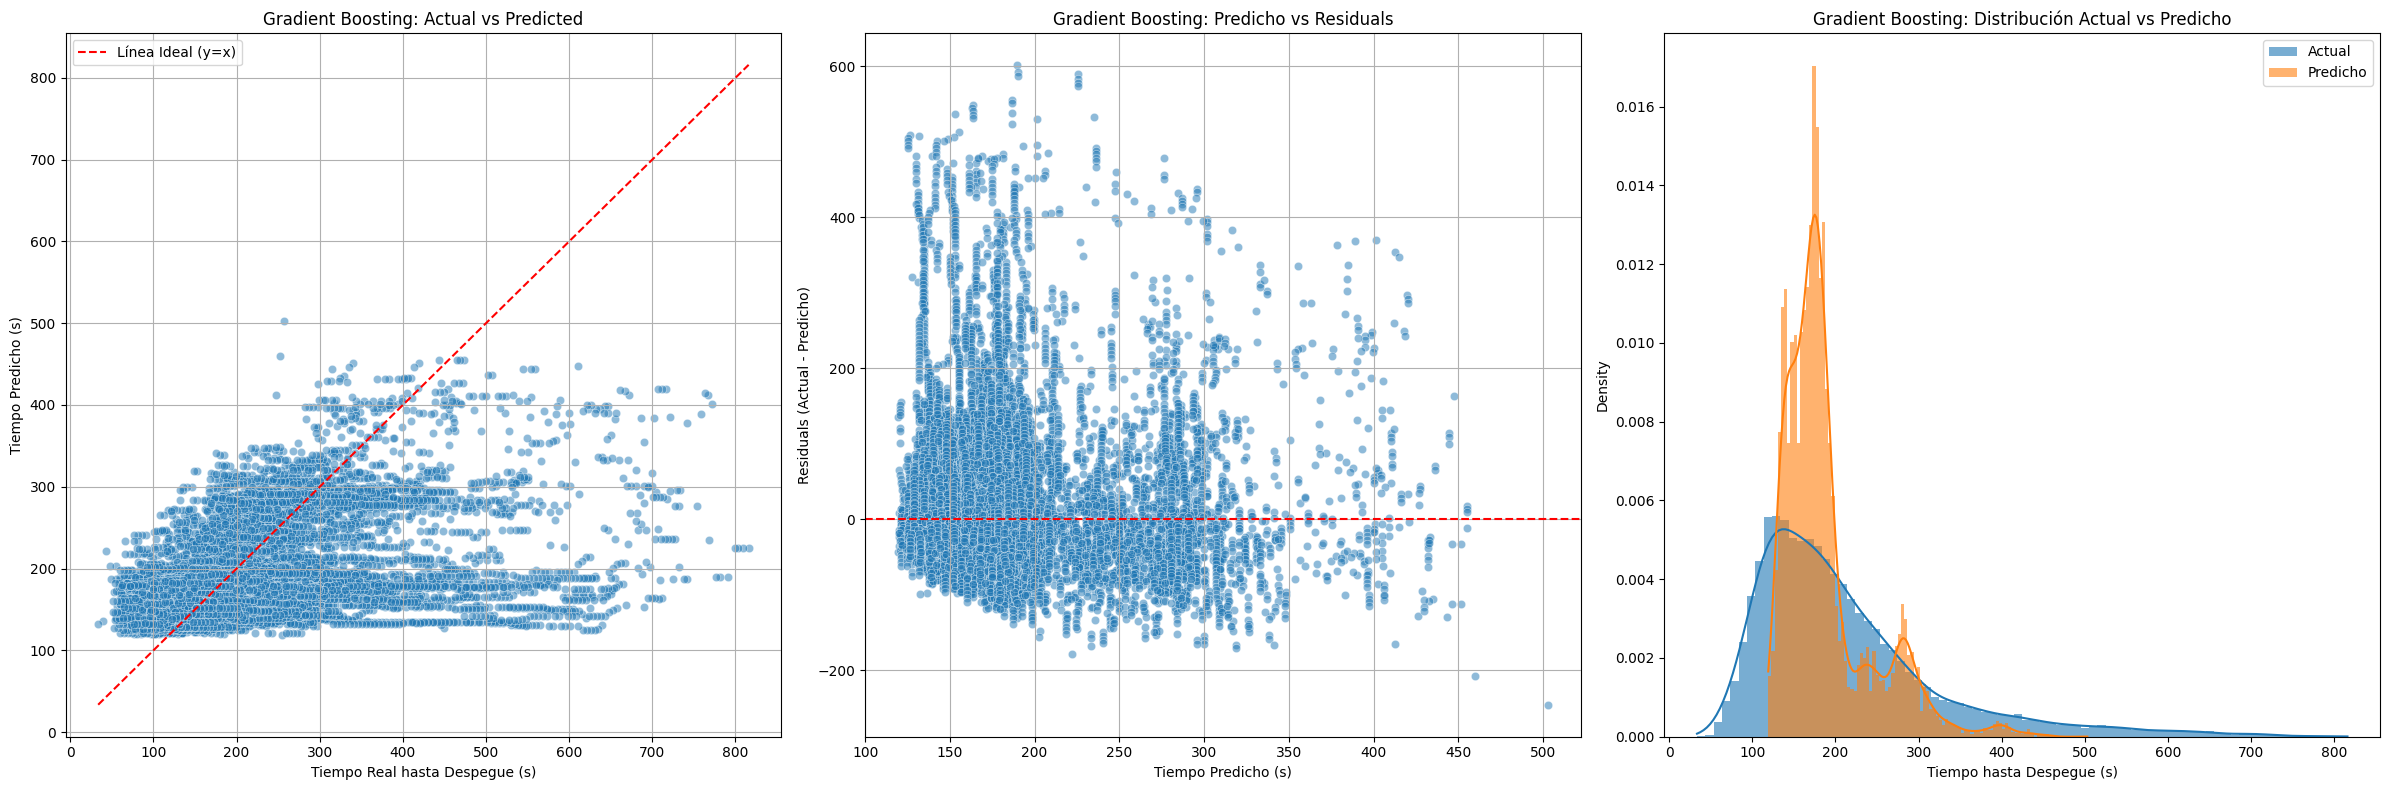

NameError: name 'runway_metrics' is not defined

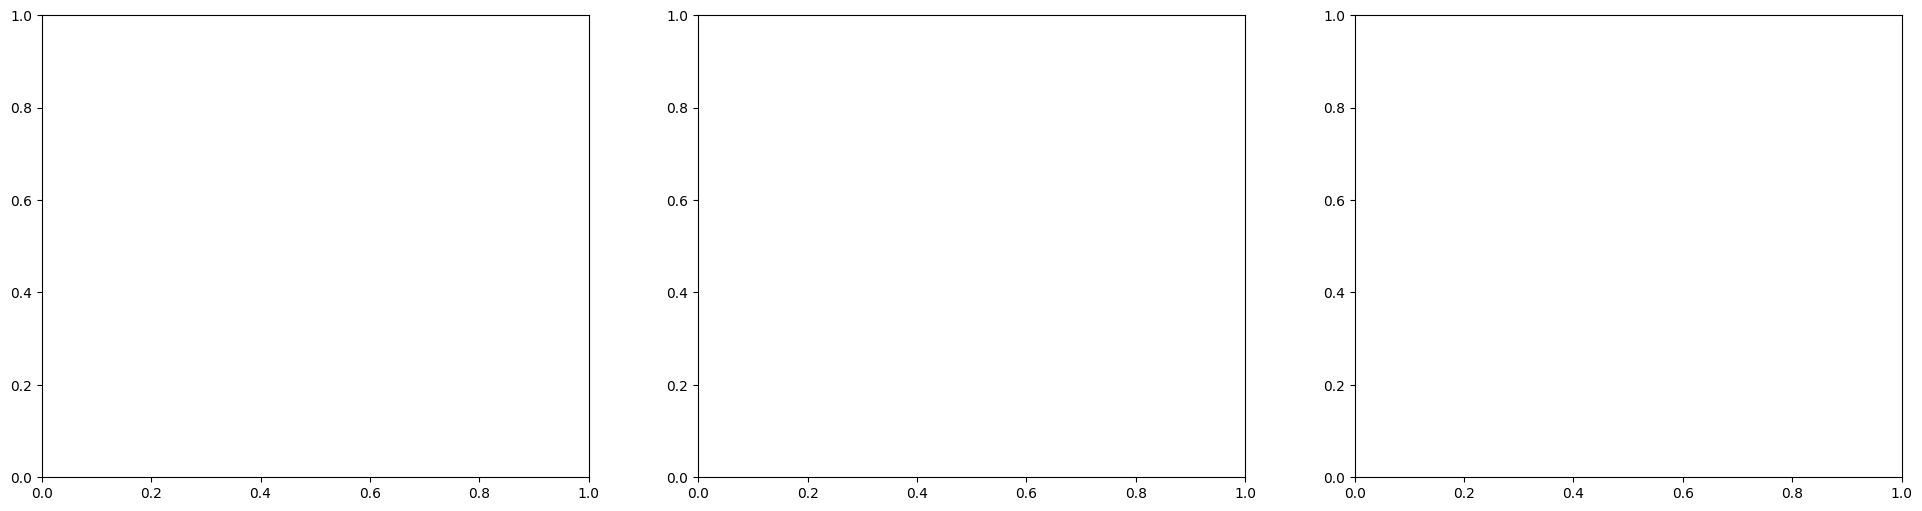

In [6]:
# 1–3: Subplots de análisis general
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# 1. Actual vs Predicho
sns.scatterplot(
    x=y_test_final, y=y_pred_best_original,
    alpha=0.5, ax=axs[0]
)
axs[0].plot(
    [y_test_final.min(), y_test_final.max()],
    [y_test_final.min(), y_test_final.max()],
    '--', color='red', label='Línea Ideal (y=x)'
)
axs[0].set_title(f'{best_model_name}: Actual vs Predicted')
axs[0].set_xlabel('Tiempo Real hasta Despegue (s)')
axs[0].set_ylabel('Tiempo Predicho (s)')
axs[0].legend()
axs[0].grid(True)

# 2. Residuals
residuals = y_test_final - y_pred_best_original
sns.scatterplot(
    x=y_pred_best_original, y=residuals,
    alpha=0.5, ax=axs[1]
)
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_title(f'{best_model_name}: Predicho vs Residuals')
axs[1].set_xlabel('Tiempo Predicho (s)')
axs[1].set_ylabel('Residuals (Actual - Predicho)')
axs[1].grid(True)

# 3. Distribución Actual vs Predicho
sns.histplot(
    y_test_final, kde=True, stat="density", linewidth=0, alpha=0.6,
    label='Actual', ax=axs[2]
)
sns.histplot(
    y_pred_best_original, kde=True, stat="density", linewidth=0, alpha=0.6,
    label='Predicho', ax=axs[2]
)
axs[2].set_title(f'{best_model_name}: Distribución Actual vs Predicho')
axs[2].set_xlabel('Tiempo hasta Despegue (s)')
axs[2].legend()

plt.tight_layout()
plt.show()


# 4–6: Subplots de análisis segmentado
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# 4. MAE por Runway
runway_metrics['MAE'].sort_values().plot(
    kind='bar', ax=axs[0], color='lightcoral'
)
axs[0].set_title(f'MAE por Runway ({best_model_name})')
axs[0].set_ylabel('MAE (s)')
axs[0].set_xlabel('Runway')
axs[0].tick_params(axis='x', rotation=0)

# 5. MAE por Holding Point (Top 10)
holding_metrics['MAE'].sort_values().plot(
    kind='bar', ax=axs[1], color='mediumseagreen'
)
axs[1].set_title(f'MAE por Holding Point (Top 10)\n({best_model_name})')
axs[1].set_ylabel('MAE (s)')
axs[1].set_xlabel('Holding Point ID')
# Sólo rotación aquí
axs[1].tick_params(axis='x', rotation=45)
# Alineamos etiquetas a la derecha
axs[1].set_xticklabels(axs[1].get_xticklabels(), ha='right')

# 6. MAE por Rango de Tiempo
time_range_metrics['MAE'].plot(
    kind='bar', ax=axs[2], color='cornflowerblue'
)
axs[2].set_title(f'MAE por Rango de Tiempo Real\n({best_model_name})')
axs[2].set_ylabel('MAE (s)')
axs[2].set_xlabel('Rango de Tiempo (s)')
axs[2].tick_params(axis='x', rotation=45)
axs[2].set_xticklabels(axs[2].get_xticklabels(), ha='right')

plt.tight_layout()
plt.show()
